In [1]:
import torch
import torch.nn as nn
import os
import copy
from torch.utils.data.dataset import ConcatDataset
from lstm_utils import MyDataset, LSTM
from tqdm import trange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# parameters
input_size = 40
hidden_layer_size = 2
bidirectional = True
batch_size = 20 #20
output_size = 1
time_window = 1

In [3]:
from sklearn.model_selection import train_test_split

file_x = np.load(r'/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction/Q3_rpi.csv_x.npy')  
file_y = np.load(r'/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction/Q3_rpi.csv_y.npy')  
X_train, X_test, y_train, y_test = train_test_split(file_x,file_y, test_size=0.2, random_state=42)

np.save(r"/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction/Q3_rpi_x_mfcc_train.csv_x.npy", X_train)
np.save(r"/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction/Q3_rpi_y_mfcc_train.csv_y.npy", y_train)
np.save(r"/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction/Q3_rpi_x_mfcc_test.csv_x.npy", X_test)
np.save(r"/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction/Q3_rpi_y_mfcc_test.csv_y.npy", y_test)

In [4]:
#create dataset 
d_path = '/home/chiahong/Documents/chihli_bee_sound/2024_rpi_vs_esp_Queenless/feature_extraction' 
X_list = ['Q3_rpi_x_mfcc_train.csv_x.npy','Q3_rpi_x_mfcc_test.csv_x.npy']
y_list = ['Q3_rpi_y_mfcc_train.csv_y.npy','Q3_rpi_y_mfcc_test.csv_y.npy']

train_0_dataset = MyDataset(os.path.join(d_path,X_list[0]),os.path.join(d_path,y_list[0]))
'''
train_1_dataset = MyDataset(os.path.join(d_path,X_list[1]),os.path.join(d_path,y_list[1]),os.path.join(d_path,time_list[1]),time_window)
train_2_dataset = MyDataset(os.path.join(d_path,X_list[2]),os.path.join(d_path,y_list[2]),os.path.join(d_path,time_list[2]),time_window)
all_dataset = [train_0_dataset,train_1_dataset,train_2_dataset]


train_0_dataset = MyDataset(os.path.join(d_path,X_list[0]),os.path.join(d_path,y_list[0]),time_window)
train_1_dataset = MyDataset(os.path.join(d_path,X_list[1]),os.path.join(d_path,y_list[1]),time_window)
train_2_dataset = MyDataset(os.path.join(d_path,X_list[2]),os.path.join(d_path,y_list[2]),time_window)
all_dataset = [train_0_dataset,train_1_dataset,train_2_dataset]

train_dataset = ConcatDataset(all_dataset)'''

valid_dataset = MyDataset(os.path.join(d_path,X_list[1]), os.path.join(d_path,y_list[1]))

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_0_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)

# test_list = ['/home/chiahong/Documents/chihli_bee_sound/featuer_extraction_and_code/Chiayi_2023/Hornet in/468_night_roll/93_test_3sec_chiayi.2min.csv_x.npy', 
#              '/home/chiahong/Documents/chihli_bee_sound/featuer_extraction_and_code/Chiayi_2023/Hornet in/468_night_roll/93_test_3sec_chiayi.2min.csv_y.npy']
# test_dataset = MyDataset(test_list[0],test_list[1])
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 調整dropout
model = LSTM(input_size, hidden_layer_size, output_size, bidirectional).to(device)
# model.load_state_dict(torch.load('/home/chihli/Documents/chiayi_foscam3_att3_508+508.test.csv_final_model_weights'))

# 可調整
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # learning rate: 1e-3 = 10^-3 = 0.001

epochs = 200
epoch_pbar = trange(epochs, desc="Epoch")     #迭代循環進度條

best_val_loss = float('inf')  # 初始化為一個非常大的值
patience = 30                 # 等待改進的時代數
early_stopping_counter = 0    # 計算沒有改進的時代數

# total_pred = []
# total_labels = []

train_losses = []  # 存儲訓練損失
val_losses = []    # 存儲驗證損失

for epoch in tqdm(epoch_pbar):
    
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    model.train()
    
    for seq, labels in tqdm(train_loader):
        
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        y_pred = model(seq)
        y_pred = y_pred.reshape(-1)
        labels = labels.reshape(-1)
        
        # backward propagation
        single_loss = loss_function(y_pred, labels)
        
        single_loss.backward()
        optimizer.step()
        train_loss += single_loss.item()
        
        # acc calculate
        
        y_pred[y_pred>0.5]=1
        y_pred[y_pred!=1]=0
        
        num_correct = (y_pred == labels).sum().item()
        acc = num_correct/batch_size
        train_acc += acc
    
    #eval
    model.eval()
    with torch.no_grad():
        for seq, labels in tqdm(valid_loader):
            seq = seq.to(device)
            labels = labels.to(device)
            
            y_pred = model(seq)
            y_pred = y_pred.reshape(-1)
            labels = labels.reshape(-1)
   
            # loss calculation
            single_loss = loss_function(y_pred, labels)
            val_loss += single_loss.item()

            # acc calculate

            y_pred[y_pred>0.5] = 1
            y_pred[y_pred!=1] = 0
            num_correct = (y_pred == labels).sum().item()
            acc = num_correct/batch_size
            val_acc += acc
    
    # print loss and acc
    train_loss /= train_loader.__len__()
    train_acc /= train_loader.__len__()
    val_loss /= valid_loader.__len__()
    val_acc /= valid_loader.__len__()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch: {epoch}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss},val_acc: {val_acc}')

    if  val_loss < best_val_loss:
        best_train_loss = train_loss
        best_val_loss = val_loss
        best_epoch = epoch
        early_stopping_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
        
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f'在{epoch}個時代後提前停止。')
        break

torch.save(best_model_weights, 'best_model_weights.pth')

# 在需要时加载最佳模型的权重
best_model = LSTM(input_size, hidden_layer_size, output_size, bidirectional).to(device)
best_model.load_state_dict(torch.load('best_model_weights.pth'))


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   0%|          | 1/200 [00:04<14:20,  4.33s/it]

Epoch: 0, train_loss: 0.1645752930184599, train_acc: 0.8094512195121933, val_loss: 0.07757444904617421,val_acc: 0.9573170731707317


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   1%|          | 2/200 [00:08<14:16,  4.33s/it]

Epoch: 1, train_loss: 0.04702131489856828, train_acc: 0.9643292682926828, val_loss: 0.024666997663699453,val_acc: 0.9804878048780489


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   2%|▏         | 3/200 [00:12<14:13,  4.33s/it]

Epoch: 2, train_loss: 0.017120889541707228, train_acc: 0.9887195121951223, val_loss: 0.01386713877280538,val_acc: 0.9847560975609758


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   2%|▏         | 4/200 [00:15<12:18,  3.77s/it]

Epoch: 3, train_loss: 0.011119518849804213, train_acc: 0.9903963414634147, val_loss: 0.2324403552338481,val_acc: 0.7149390243902437


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   2%|▎         | 5/200 [00:20<12:46,  3.93s/it]

Epoch: 4, train_loss: 0.008833582168757325, train_acc: 0.9907012195121953, val_loss: 0.007745469048109598,val_acc: 0.990548780487805


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   3%|▎         | 6/200 [00:23<11:35,  3.59s/it]

Epoch: 5, train_loss: 0.007815048406483562, train_acc: 0.9914634146341467, val_loss: 0.0021044672409139243,val_acc: 0.9966463414634149


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   4%|▎         | 7/200 [00:25<10:49,  3.37s/it]

Epoch: 6, train_loss: 0.0056847829449374904, train_acc: 0.9935975609756103, val_loss: 0.0021967074717395008,val_acc: 0.9963414634146344


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   4%|▍         | 8/200 [00:28<10:18,  3.22s/it]

Epoch: 7, train_loss: 0.005478705587903256, train_acc: 0.9932164634146342, val_loss: 0.001836305446376195,val_acc: 0.9969512195121953


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   4%|▍         | 9/200 [00:31<09:57,  3.13s/it]

Epoch: 8, train_loss: 0.005316260834516891, train_acc: 0.9933689024390246, val_loss: 0.006616229554421762,val_acc: 0.9923780487804879


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   5%|▌         | 10/200 [00:34<09:41,  3.06s/it]

Epoch: 9, train_loss: 0.004615397854727568, train_acc: 0.994054878048781, val_loss: 0.016441551597536755,val_acc: 0.9801829268292684


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   6%|▌         | 11/200 [00:37<09:30,  3.02s/it]

Epoch: 10, train_loss: 0.007076038629738222, train_acc: 0.9912347560975606, val_loss: 0.004856272767489006,val_acc: 0.99359756097561


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   6%|▌         | 12/200 [00:40<09:21,  2.99s/it]

Epoch: 11, train_loss: 0.004877418539677354, train_acc: 0.993978658536586, val_loss: 0.017824639480977567,val_acc: 0.9786585365853657


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   6%|▋         | 13/200 [00:43<09:15,  2.97s/it]

Epoch: 12, train_loss: 0.004477108229979222, train_acc: 0.9939786585365855, val_loss: 0.005481213501969073,val_acc: 0.9929878048780489


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   7%|▋         | 14/200 [00:46<09:09,  2.95s/it]

Epoch: 13, train_loss: 0.0060008637645943864, train_acc: 0.9919969512195117, val_loss: 0.004732115143413955,val_acc: 0.9932926829268295


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   8%|▊         | 15/200 [00:49<09:15,  3.00s/it]

Epoch: 14, train_loss: 0.005331308779034316, train_acc: 0.9932926829268289, val_loss: 0.005769894772506299,val_acc: 0.9926829268292684


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   8%|▊         | 16/200 [00:53<10:26,  3.40s/it]

Epoch: 15, train_loss: 0.003996835039248065, train_acc: 0.9942835365853661, val_loss: 0.0015680721245943704,val_acc: 0.9969512195121953


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   8%|▊         | 17/200 [00:58<11:14,  3.69s/it]

Epoch: 16, train_loss: 0.004760918545228117, train_acc: 0.9935213414634148, val_loss: 0.00160037873860258,val_acc: 0.9969512195121953


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:   9%|▉         | 18/200 [01:01<11:07,  3.67s/it]

Epoch: 17, train_loss: 0.00563969531974247, train_acc: 0.9924542682926834, val_loss: 0.001299722792714974,val_acc: 0.9972560975609757


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  10%|▉         | 19/200 [01:05<10:53,  3.61s/it]

Epoch: 18, train_loss: 0.0035568407140794435, train_acc: 0.994969512195122, val_loss: 0.010035561055036208,val_acc: 0.9884146341463416


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  10%|█         | 20/200 [01:09<11:17,  3.76s/it]

Epoch: 19, train_loss: 0.004221178829030513, train_acc: 0.9945121951219513, val_loss: 0.001831767979574468,val_acc: 0.9963414634146344


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  10%|█         | 21/200 [01:12<10:36,  3.55s/it]

Epoch: 20, train_loss: 0.004477471516436052, train_acc: 0.9937499999999999, val_loss: 0.007689708322568938,val_acc: 0.9911585365853658


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  11%|█         | 22/200 [01:15<10:13,  3.44s/it]

Epoch: 21, train_loss: 0.003657401686953607, train_acc: 0.9944359756097563, val_loss: 0.008377813176710377,val_acc: 0.9905487804878048


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 23/200 [01:18<09:43,  3.30s/it]

Epoch: 22, train_loss: 0.0034318058463878465, train_acc: 0.9950457317073172, val_loss: 0.002008674970500401,val_acc: 0.9960365853658538


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 24/200 [01:21<09:21,  3.19s/it]

Epoch: 23, train_loss: 0.004375636340323401, train_acc: 0.9948932926829274, val_loss: 0.00159499697260258,val_acc: 0.9969512195121953


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  12%|█▎        | 25/200 [01:24<09:05,  3.12s/it]

Epoch: 24, train_loss: 0.004462544663361798, train_acc: 0.9936737804878049, val_loss: 0.007594372027400402,val_acc: 0.9908536585365854


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  13%|█▎        | 26/200 [01:28<09:41,  3.34s/it]

Epoch: 25, train_loss: 0.0035286643481253926, train_acc: 0.994740853658537, val_loss: 0.0012978612335585672,val_acc: 0.9969512195121953


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  14%|█▎        | 27/200 [01:32<10:29,  3.64s/it]

Epoch: 26, train_loss: 0.003748604772293245, train_acc: 0.9946646341463418, val_loss: 0.006351224221904703,val_acc: 0.9920731707317072


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 28/200 [01:37<11:01,  3.85s/it]

Epoch: 27, train_loss: 0.003430948434333125, train_acc: 0.9959603658536584, val_loss: 0.007566092722945527,val_acc: 0.990548780487805


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 29/200 [01:41<11:23,  4.00s/it]

Epoch: 28, train_loss: 0.004488289155792003, train_acc: 0.9942835365853664, val_loss: 0.009581782818514739,val_acc: 0.9884146341463416


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 30/200 [01:45<11:30,  4.06s/it]

Epoch: 29, train_loss: 0.003594245818009633, train_acc: 0.9948932926829271, val_loss: 0.007924933355924644,val_acc: 0.9905487804878051


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 31/200 [01:48<10:26,  3.70s/it]

Epoch: 30, train_loss: 0.004336004900416846, train_acc: 0.993826219512195, val_loss: 0.014452587497021618,val_acc: 0.9832317073170733


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 32/200 [01:51<10:13,  3.65s/it]

Epoch: 31, train_loss: 0.0030209562828649767, train_acc: 0.9951981707317074, val_loss: 0.0035480632456853537,val_acc: 0.9951219512195121


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  16%|█▋        | 33/200 [01:55<10:07,  3.63s/it]

Epoch: 32, train_loss: 0.0031628129343951508, train_acc: 0.9958079268292684, val_loss: 0.002358653733281466,val_acc: 0.9966463414634146


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  17%|█▋        | 34/200 [01:58<09:41,  3.50s/it]

Epoch: 33, train_loss: 0.0045899195968600835, train_acc: 0.9939024390243905, val_loss: 0.014153055174928085,val_acc: 0.9832317073170733


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 35/200 [02:03<10:20,  3.76s/it]

Epoch: 34, train_loss: 0.002884470871406533, train_acc: 0.9955792682926826, val_loss: 0.006240581911710689,val_acc: 0.9923780487804879


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 36/200 [02:07<10:45,  3.94s/it]

Epoch: 35, train_loss: 0.0027718896700170206, train_acc: 0.9958841463414635, val_loss: 0.004412798844294606,val_acc: 0.9935975609756097


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 37/200 [02:11<11:03,  4.07s/it]

Epoch: 36, train_loss: 0.003206883874208262, train_acc: 0.9950457317073172, val_loss: 0.007711824141246208,val_acc: 0.9908536585365854


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  19%|█▉        | 38/200 [02:16<11:13,  4.16s/it]

Epoch: 37, train_loss: 0.0030762485318489683, train_acc: 0.995655487804878, val_loss: 0.0034191202469489143,val_acc: 0.9951219512195121


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  20%|█▉        | 39/200 [02:20<11:19,  4.22s/it]

Epoch: 38, train_loss: 0.0028811078911963653, train_acc: 0.9953506097560971, val_loss: 0.002278065906975673,val_acc: 0.9960365853658535


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  20%|██        | 40/200 [02:24<11:22,  4.27s/it]

Epoch: 39, train_loss: 0.002869695355753833, train_acc: 0.9954268292682925, val_loss: 0.005382272458918839,val_acc: 0.9929878048780487


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  20%|██        | 41/200 [02:29<11:23,  4.30s/it]

Epoch: 40, train_loss: 0.003870076305339605, train_acc: 0.9945884146341466, val_loss: 0.00157304025510268,val_acc: 0.9966463414634146


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  21%|██        | 42/200 [02:32<10:37,  4.04s/it]

Epoch: 41, train_loss: 0.002450876243169631, train_acc: 0.9960365853658539, val_loss: 0.0025383527738824796,val_acc: 0.9960365853658535


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 43/200 [02:35<09:43,  3.72s/it]

Epoch: 42, train_loss: 0.002893698474283351, train_acc: 0.9954268292682927, val_loss: 0.010347556042246396,val_acc: 0.9875000000000002


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 44/200 [02:38<09:04,  3.49s/it]

Epoch: 43, train_loss: 0.002844086198149099, train_acc: 0.9956554878048789, val_loss: 0.011737722891109293,val_acc: 0.9865853658536586


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  22%|██▎       | 45/200 [02:42<09:37,  3.72s/it]

Epoch: 44, train_loss: 0.0034902290079756385, train_acc: 0.995731707317073, val_loss: 0.001276696367141236,val_acc: 0.9972560975609757


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  23%|██▎       | 46/200 [02:45<08:56,  3.48s/it]

Epoch: 45, train_loss: 0.003976580191443221, train_acc: 0.9952743902439022, val_loss: 0.006152871515773657,val_acc: 0.9926829268292684


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  24%|██▎       | 47/200 [02:49<08:38,  3.39s/it]

Epoch: 46, train_loss: 0.002093935101344279, train_acc: 0.9963414634146338, val_loss: 0.0030592930085094434,val_acc: 0.9951219512195121


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 48/200 [02:53<09:19,  3.68s/it]

Epoch: 47, train_loss: 0.0021601788108133804, train_acc: 0.9964939024390246, val_loss: 0.019430865446037577,val_acc: 0.9768292682926829


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 49/200 [02:57<09:50,  3.91s/it]

Epoch: 48, train_loss: 0.0033723681350040753, train_acc: 0.9951981707317079, val_loss: 0.021340522628571675,val_acc: 0.9746951219512197


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 50/200 [03:02<10:07,  4.05s/it]

Epoch: 49, train_loss: 0.0028564381663583314, train_acc: 0.995655487804878, val_loss: 0.005857967004994903,val_acc: 0.9926829268292684


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 51/200 [03:06<10:18,  4.15s/it]

Epoch: 50, train_loss: 0.0026831061171283493, train_acc: 0.9963414634146347, val_loss: 0.0051564391309674405,val_acc: 0.9932926829268293


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 52/200 [03:10<10:24,  4.22s/it]

Epoch: 51, train_loss: 0.0026418392328409626, train_acc: 0.9959603658536584, val_loss: 0.00581549928888765,val_acc: 0.9926829268292684


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  26%|██▋       | 53/200 [03:15<10:27,  4.27s/it]

Epoch: 52, train_loss: 0.0027392640546316056, train_acc: 0.9956554878048779, val_loss: 0.013316431191155028,val_acc: 0.9844512195121953


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  27%|██▋       | 54/200 [03:19<10:27,  4.30s/it]

Epoch: 53, train_loss: 0.0025323362117727318, train_acc: 0.9959603658536585, val_loss: 0.004434075905953046,val_acc: 0.9942073170731707


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 55/200 [03:24<10:26,  4.32s/it]

Epoch: 54, train_loss: 0.0022130729112881764, train_acc: 0.9961890243902437, val_loss: 0.00652444177554951,val_acc: 0.9923780487804879


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 56/200 [03:28<10:24,  4.34s/it]

Epoch: 55, train_loss: 0.0026260743695260833, train_acc: 0.9964939024390246, val_loss: 0.004603607941085039,val_acc: 0.9935975609756097


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 57/200 [03:32<10:22,  4.35s/it]

Epoch: 56, train_loss: 0.0032013345691443824, train_acc: 0.9955792682926832, val_loss: 0.013373479132108497,val_acc: 0.9841463414634146


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  29%|██▉       | 58/200 [03:37<10:19,  4.36s/it]

Epoch: 57, train_loss: 0.0021185786797837925, train_acc: 0.996265243902439, val_loss: 0.006387490736118507,val_acc: 0.9920731707317074


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  30%|██▉       | 59/200 [03:41<10:15,  4.36s/it]

Epoch: 58, train_loss: 0.0031229763816008373, train_acc: 0.9962652439024391, val_loss: 0.0045228544544001735,val_acc: 0.99390243902439


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  30%|███       | 60/200 [03:46<10:11,  4.37s/it]

Epoch: 59, train_loss: 0.0023758167258357203, train_acc: 0.9960365853658539, val_loss: 0.015572133158900946,val_acc: 0.9820121951219513


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  30%|███       | 61/200 [03:50<10:07,  4.37s/it]

Epoch: 60, train_loss: 0.002755137307593174, train_acc: 0.9957317073170733, val_loss: 0.0015038089960388741,val_acc: 0.9969512195121951


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  31%|███       | 62/200 [03:54<10:03,  4.37s/it]

Epoch: 61, train_loss: 0.002270842107484687, train_acc: 0.9962652439024391, val_loss: 0.006323980415371427,val_acc: 0.9917682926829269


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 63/200 [03:59<09:59,  4.37s/it]

Epoch: 62, train_loss: 0.002689282088136623, train_acc: 0.9964176829268294, val_loss: 0.010959598037802153,val_acc: 0.9865853658536586


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 64/200 [04:03<09:54,  4.37s/it]

Epoch: 63, train_loss: 0.002465716440903334, train_acc: 0.9964939024390242, val_loss: 0.005286044384321074,val_acc: 0.9929878048780487


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  32%|███▎      | 65/200 [04:06<08:53,  3.95s/it]

Epoch: 64, train_loss: 0.0020962188879109027, train_acc: 0.9962652439024391, val_loss: 0.004277880527042282,val_acc: 0.9942073170731707


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  33%|███▎      | 66/200 [04:09<08:09,  3.66s/it]

Epoch: 65, train_loss: 0.0034292671076941706, train_acc: 0.994969512195122, val_loss: 0.004563683642392634,val_acc: 0.9942073170731707


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  34%|███▎      | 67/200 [04:13<08:34,  3.87s/it]

Epoch: 66, train_loss: 0.0018876273231475576, train_acc: 0.9967987804878048, val_loss: 0.010776756837648666,val_acc: 0.986890243902439


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 68/200 [04:18<08:50,  4.02s/it]

Epoch: 67, train_loss: 0.002609226762867299, train_acc: 0.9963414634146345, val_loss: 0.0024412409769987748,val_acc: 0.9960365853658536


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 69/200 [04:22<08:58,  4.11s/it]

Epoch: 68, train_loss: 0.0016214321345483372, train_acc: 0.9967987804878048, val_loss: 0.013415099300936519,val_acc: 0.983231707317073


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  35%|███▌      | 70/200 [04:26<08:48,  4.07s/it]

Epoch: 69, train_loss: 0.0017136765905917909, train_acc: 0.9967987804878047, val_loss: 0.005681264085488116,val_acc: 0.9929878048780487


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 71/200 [04:30<08:56,  4.16s/it]

Epoch: 70, train_loss: 0.0014589299220414977, train_acc: 0.9971036585365856, val_loss: 0.010676520482888918,val_acc: 0.9871951219512195


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 72/200 [04:35<09:00,  4.23s/it]

Epoch: 71, train_loss: 0.0019420335236556042, train_acc: 0.9966463414634147, val_loss: 0.003985906700859128,val_acc: 0.9948170731707315


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  36%|███▋      | 73/200 [04:39<09:02,  4.27s/it]

Epoch: 72, train_loss: 0.0021389819725067503, train_acc: 0.9962652439024388, val_loss: 0.000928780936227811,val_acc: 0.9975609756097561


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  37%|███▋      | 74/200 [04:43<09:02,  4.30s/it]

Epoch: 73, train_loss: 0.003962414660810945, train_acc: 0.9954268292682928, val_loss: 0.026719628281405332,val_acc: 0.9679878048780491


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 75/200 [04:48<09:00,  4.33s/it]

Epoch: 74, train_loss: 0.0017896363584062487, train_acc: 0.9967225609756094, val_loss: 0.005638230458792228,val_acc: 0.9926829268292682


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 76/200 [04:52<08:58,  4.34s/it]

Epoch: 75, train_loss: 0.0022416338829498233, train_acc: 0.9961890243902444, val_loss: 0.006481692155813751,val_acc: 0.9914634146341463


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 77/200 [04:57<08:55,  4.35s/it]

Epoch: 76, train_loss: 0.0016284467246601804, train_acc: 0.9967987804878048, val_loss: 0.005869565592764216,val_acc: 0.9923780487804876


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  39%|███▉      | 78/200 [05:01<08:51,  4.36s/it]

Epoch: 77, train_loss: 0.0029196317334066507, train_acc: 0.9961890243902437, val_loss: 0.0062695891191850706,val_acc: 0.9920731707317072


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  40%|███▉      | 79/200 [05:05<08:48,  4.36s/it]

Epoch: 78, train_loss: 0.0016728373377882541, train_acc: 0.99702743902439, val_loss: 0.012511908460619147,val_acc: 0.9841463414634146


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  40%|████      | 80/200 [05:10<08:44,  4.37s/it]

Epoch: 79, train_loss: 0.001619436321360591, train_acc: 0.9971036585365854, val_loss: 0.005356196536831149,val_acc: 0.9926829268292682


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  40%|████      | 81/200 [05:14<08:39,  4.37s/it]

Epoch: 80, train_loss: 0.0025854749814850377, train_acc: 0.9963414634146345, val_loss: 0.0024196537224209632,val_acc: 0.9960365853658536


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  41%|████      | 82/200 [05:18<08:35,  4.37s/it]

Epoch: 81, train_loss: 0.0020514128480778036, train_acc: 0.9961890243902437, val_loss: 0.011363031244645588,val_acc: 0.9862804878048782


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 83/200 [05:23<08:30,  4.36s/it]

Epoch: 82, train_loss: 0.0017082457865748267, train_acc: 0.9968749999999998, val_loss: 0.008943630557462742,val_acc: 0.988719512195122


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 84/200 [05:27<08:25,  4.35s/it]

Epoch: 83, train_loss: 0.0015019488194906306, train_acc: 0.9968749999999998, val_loss: 0.029197838938657475,val_acc: 0.9637195121951222


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  42%|████▎     | 85/200 [05:31<08:16,  4.32s/it]

Epoch: 84, train_loss: 0.0023914275359727326, train_acc: 0.9964939024390242, val_loss: 0.021658216329491782,val_acc: 0.9734756097560974


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  43%|████▎     | 86/200 [05:36<08:14,  4.34s/it]

Epoch: 85, train_loss: 0.0020408504639127666, train_acc: 0.9962652439024391, val_loss: 0.028881844728689928,val_acc: 0.9661585365853663


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  44%|████▎     | 87/200 [05:40<08:10,  4.34s/it]

Epoch: 86, train_loss: 0.0018217507528443654, train_acc: 0.997408536585366, val_loss: 0.0005928382546749918,val_acc: 0.9981707317073172


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 88/200 [05:45<08:07,  4.35s/it]

Epoch: 87, train_loss: 0.0014895735239311683, train_acc: 0.9972560975609757, val_loss: 0.1027914216063259,val_acc: 0.8878048780487808


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 89/200 [05:49<08:03,  4.36s/it]

Epoch: 88, train_loss: 0.002924784057469288, train_acc: 0.9960365853658536, val_loss: 0.01876183163507332,val_acc: 0.9774390243902438


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  45%|████▌     | 90/200 [05:53<07:59,  4.36s/it]

Epoch: 89, train_loss: 0.0021325708419924626, train_acc: 0.9966463414634147, val_loss: 0.0043199178837748185,val_acc: 0.9945121951219512


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 91/200 [05:57<07:40,  4.23s/it]

Epoch: 90, train_loss: 0.0013172006951703706, train_acc: 0.9971798780487808, val_loss: 0.0057256611770297675,val_acc: 0.9926829268292682


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 92/200 [06:01<07:12,  4.00s/it]

Epoch: 91, train_loss: 0.002061124782015981, train_acc: 0.9963414634146344, val_loss: 0.006518722183671408,val_acc: 0.9917682926829267


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  46%|████▋     | 93/200 [06:05<07:19,  4.11s/it]

Epoch: 92, train_loss: 0.0027970433082480425, train_acc: 0.996265243902439, val_loss: 0.020622021233260693,val_acc: 0.9765243902439023


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  47%|████▋     | 94/200 [06:09<07:23,  4.18s/it]

Epoch: 93, train_loss: 0.0013613890521646575, train_acc: 0.9972560975609759, val_loss: 0.002594593233642753,val_acc: 0.9957317073170731


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 95/200 [06:12<06:39,  3.81s/it]

Epoch: 94, train_loss: 0.001617139340952393, train_acc: 0.9968749999999998, val_loss: 0.018230216487275706,val_acc: 0.9780487804878049


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 96/200 [06:15<06:08,  3.54s/it]

Epoch: 95, train_loss: 0.0022324007013146394, train_acc: 0.9964176829268289, val_loss: 0.010378172817688207,val_acc: 0.986890243902439


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 97/200 [06:18<05:46,  3.36s/it]

Epoch: 96, train_loss: 0.0015708403922491412, train_acc: 0.9967987804878048, val_loss: 0.012150373938941661,val_acc: 0.9835365853658535


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  49%|████▉     | 98/200 [06:21<05:29,  3.23s/it]

Epoch: 97, train_loss: 0.0022385185724580264, train_acc: 0.9972560975609757, val_loss: 0.06817277154826923,val_acc: 0.9234756097560985


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  50%|████▉     | 99/200 [06:24<05:17,  3.15s/it]

Epoch: 98, train_loss: 0.002579031066233597, train_acc: 0.9964939024390245, val_loss: 0.019004136279543827,val_acc: 0.977439024390244


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  50%|█████     | 100/200 [06:27<05:08,  3.08s/it]

Epoch: 99, train_loss: 0.0016311316796533035, train_acc: 0.9967225609756096, val_loss: 0.02074350284561628,val_acc: 0.9768292682926829


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  50%|█████     | 101/200 [06:30<05:00,  3.04s/it]

Epoch: 100, train_loss: 0.0012735477253765267, train_acc: 0.9974085365853661, val_loss: 0.007842581516951056,val_acc: 0.9902439024390244


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  51%|█████     | 102/200 [06:34<05:36,  3.43s/it]

Epoch: 101, train_loss: 0.0015433337325695975, train_acc: 0.9975609756097562, val_loss: 0.005413591166227254,val_acc: 0.9932926829268292


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 103/200 [06:39<06:00,  3.72s/it]

Epoch: 102, train_loss: 0.002802810919351444, train_acc: 0.9966463414634144, val_loss: 0.003010758151599425,val_acc: 0.9954268292682925


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 104/200 [06:43<06:15,  3.92s/it]

Epoch: 103, train_loss: 0.002237439339087301, train_acc: 0.9962652439024388, val_loss: 0.013680816594085685,val_acc: 0.9832317073170732


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  52%|█████▎    | 105/200 [06:47<06:25,  4.05s/it]

Epoch: 104, train_loss: 0.0014819824138002512, train_acc: 0.9971036585365856, val_loss: 0.024382312531312154,val_acc: 0.9713414634146346


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  53%|█████▎    | 106/200 [06:52<06:30,  4.15s/it]

Epoch: 105, train_loss: 0.002252884343796953, train_acc: 0.9967225609756096, val_loss: 0.004503857752365162,val_acc: 0.99390243902439


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  54%|█████▎    | 107/200 [06:56<06:32,  4.22s/it]

Epoch: 106, train_loss: 0.0017782249575075356, train_acc: 0.9967987804878048, val_loss: 0.015285297402950444,val_acc: 0.9820121951219511


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 108/200 [07:01<06:33,  4.27s/it]

Epoch: 107, train_loss: 0.0016602255570401135, train_acc: 0.9968749999999998, val_loss: 0.00830659604088238,val_acc: 0.9893292682926828


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  55%|█████▍    | 109/200 [07:05<06:31,  4.31s/it]

Epoch: 108, train_loss: 0.0018466299795026112, train_acc: 0.9967225609756105, val_loss: 0.004423082873340884,val_acc: 0.9935975609756097


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  55%|█████▌    | 110/200 [07:09<06:29,  4.33s/it]

Epoch: 109, train_loss: 0.0023190922821946804, train_acc: 0.9964939024390246, val_loss: 0.003824788885735924,val_acc: 0.995121951219512


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 111/200 [07:14<06:26,  4.34s/it]

Epoch: 110, train_loss: 0.0013403826801953313, train_acc: 0.9971798780487806, val_loss: 0.020108191952047952,val_acc: 0.9765243902439023


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 112/200 [07:18<06:22,  4.35s/it]

Epoch: 111, train_loss: 0.002136118121256421, train_acc: 0.99702743902439, val_loss: 0.009179407991040058,val_acc: 0.9884146341463415


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  56%|█████▋    | 113/200 [07:22<06:19,  4.36s/it]

Epoch: 112, train_loss: 0.0018944299584891672, train_acc: 0.9969512195121953, val_loss: 0.029153057325030627,val_acc: 0.9649390243902443


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  57%|█████▋    | 114/200 [07:27<06:15,  4.36s/it]

Epoch: 113, train_loss: 0.0011437252312210579, train_acc: 0.997408536585366, val_loss: 0.03268367029901134,val_acc: 0.9600609756097566


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  57%|█████▊    | 115/200 [07:31<06:11,  4.37s/it]

Epoch: 114, train_loss: 0.0022546123285946637, train_acc: 0.9961890243902439, val_loss: 0.004458154332411281,val_acc: 0.9935975609756095


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 116/200 [07:36<06:07,  4.37s/it]

Epoch: 115, train_loss: 0.0015053068021167392, train_acc: 0.9970274390243905, val_loss: 0.012598245004257045,val_acc: 0.9847560975609756


  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 116/200 [07:40<05:33,  3.97s/it]

Epoch: 116, train_loss: 0.0011736134580419243, train_acc: 0.9973323170731709, val_loss: 0.018809717492253936,val_acc: 0.976829268292683
在116個時代後提前停止。


<All keys matched successfully>

In [7]:
print(f'best_epoch : {best_epoch}, best_train_loss : {best_train_loss}, best_val_loss : {best_val_loss}')

best_epoch : 184, best_train_loss : 0.09049876555489997, best_val_loss : 0.08223261669474213


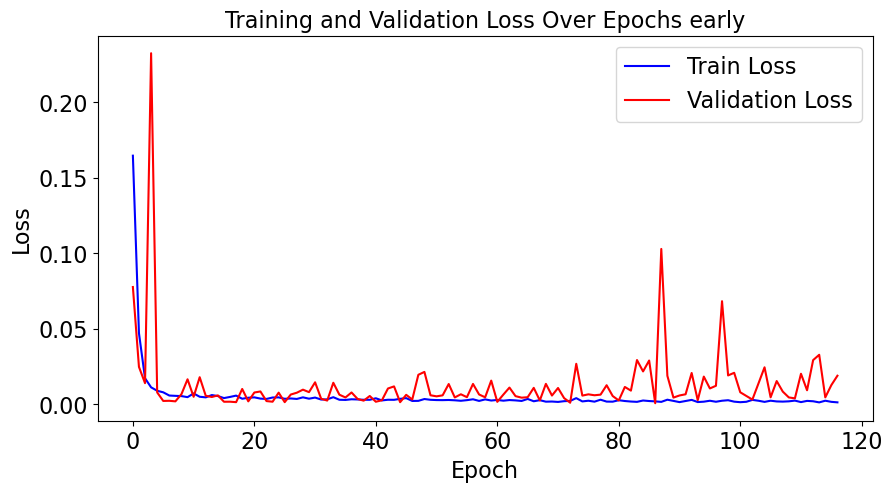

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(epoch+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(epoch+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.title('Training and Validation Loss Over Epochs early', fontsize = 16)
plt.show()

In [21]:
# torch.save(model.state_dict(), '/home/chiahong/Documents/chihli_bee_sound/featuer_extraction_and_code/Chiayi_2023/Hornet in/468_night_roll/test_3sec_chiayi.2min_night.csv_final_model_weights')

In [8]:
#eval
# model.load_state_dict(torch.load('/home/chihli/Documents/chiayi_foscam3_att3_508+508.test.csv_final_model_weights'))
# model.load_state_dict(best_model_weights)
model.eval()
acc_acc=[]
val_loss = 0
val_acc = 0
acc_acc=[]
a=[]
b=[]
with torch.no_grad():
    for seq, labels in tqdm(valid_loader):
        seq = seq.to(device)
        labels = labels.to(device)

        y_pred = model(seq)
        y_pred = y_pred.reshape(-1)
        labels  = labels.reshape(-1)

        # loss calculation
        single_loss = loss_function(y_pred, labels)
        val_loss += single_loss.item()

        # acc calculate

        y_pred[y_pred>0.5]=1
        y_pred[y_pred!=1]=0
        a.extend(y_pred.view(-1).detach().cpu().numpy())       
        b.extend(labels.view(-1).detach().cpu().numpy())
        num_correct = (y_pred == labels).sum().item()
        acc = num_correct/batch_size
        acc_acc.append(acc)
        val_acc += acc
    
    # print loss and acc
    
    val_loss /= valid_loader.__len__()
    val_acc /= valid_loader.__len__()
    
    print(f'val_loss: {val_loss}, val_acc: {val_acc}')
    print(f'valid_loader : {len(valid_loader)}')

  0%|          | 0/164 [00:00<?, ?it/s]

val_loss: 0.018809717492253936, val_acc: 0.976829268292683
valid_loader : 164


TP: 1716, TN: 1488, FP: 0, FN: 72
Accuracy  : 0.98
Precision : 1.00
Recall    : 0.96


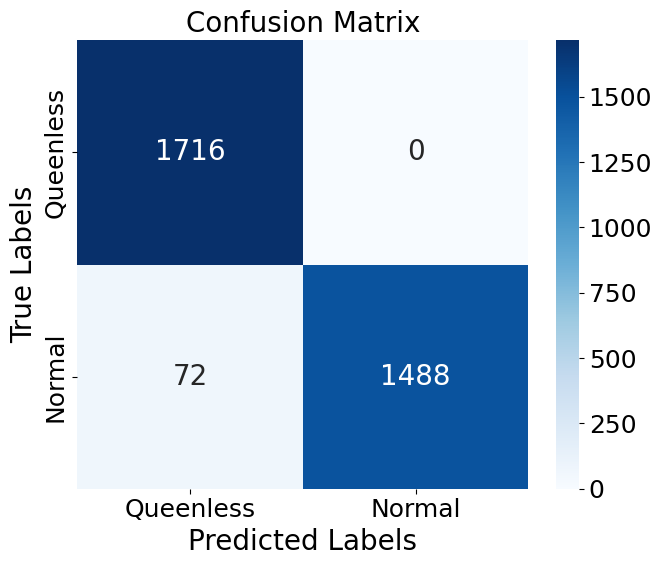

In [10]:
import pandas as pd

cm = confusion_matrix(b, a)
df_cm = pd.DataFrame(cm, index=['Queenless', 'Normal'], columns=['Queenless', 'Normal'])

fig, axes = plt.subplots(1, 1, figsize=(7, 6))
plt.rcParams.update({'font.size': 18})
sns.heatmap(df_cm, annot=True, ax=axes, cmap='Blues', fmt="d", annot_kws={"fontsize": 20})
axes.set_title('Confusion Matrix', fontsize=20)
axes.set_xlabel('Predicted Labels', fontsize=20)
axes.set_ylabel('True Labels', fontsize=20)

# Calculate precision, recall, and accuracy
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Display precision, recall, and accuracy
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
print(f'Accuracy  : {accuracy:.2f}')
print(f'Precision : {precision:.2f}')
print(f'Recall    : {recall:.2f}')

# save_folder = '/home/chihli/Desktop/chiayi_Hornet_in_random_roll_flip_confusion_matrix/batch_size_50-Epochs_200'  # 替换为要保存图像的文件夹路径
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)

plt.tight_layout()
# plt.savefig(f'{save_folder}/Confusion_matrix_5.png')  
plt.show()

In [10]:
# df_cm.to_csv('5sec_chiayi_Hornet_in_968+968.random.roll_confusion_matrix_early2.csv')

In [12]:
confusion_matrix_df = pd.read_csv('5sec_chiayi_Hornet_in_968+968.random.roll_confusion_matrix_1.csv', index_col=0)  # 设置index_col参数以指定索引列

fig, axes = plt.subplots(1,1, figsize = (7,6))
plt.rcParams.update({'font.size': 16})
sns.heatmap(df_cm, annot=True, ax=axes, cmap='Blues', fmt="d", annot_kws={"fontsize": 20})
axes.set_title('Confusion Matrix', fontsize=18)
axes.set_xlabel('Predicted Labels', fontsize=18)
axes.set_ylabel('True Labels', fontsize=18)

plt.tight_layout()
plt.show()

KeyError: 'True Positive'